In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
demographic = pd.read_csv('demographic.csv')

In [4]:
# function to recode the ethnicity column based on the given conditions
def recode_ethnicity(cell):
    if 'ASIAN' in cell:
        return 'ASIAN'
    elif 'WHITE' in cell:
        return 'WHITE'
    elif 'BLACK' in cell:
        return 'BLACK'
    elif 'HISPANIC' in cell:
        return 'HISPANIC'
    else:
        return 'OTHERS'

demographic['ethnicity'] = demographic['ethnicity'].apply(recode_ethnicity)

In [5]:
numerical_columns = ['age', 'bmi', 'avg_sofa_score']
categorical_columns = ['mech_vent', 'gender', 'ethnicity', 'metastatic_cancer', 'admission_type']

# select the specified features into a new DataFrame called 'demo_filtered'
demo_filtered = demographic[numerical_columns + ['mortality'] + categorical_columns + ['subject_id']]

In [6]:
# one-hot encoding on the categorical variables within the demo_filtered dataframe
demo_filtered_encoded = pd.get_dummies(demo_filtered, columns=categorical_columns)

In [7]:
# initialize the MICE imputer
mice_imputer = IterativeImputer(random_state=19437278)

# fit the imputer and transform the DataFrame
df_imputed = pd.DataFrame(mice_imputer.fit_transform(demo_filtered_encoded), columns=demo_filtered_encoded.columns)

In [8]:
# split the data into features (X) and target (y)
X = df_imputed.drop(['mortality', 'subject_id'], axis=1)
y = df_imputed['mortality']

# standardization
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=19437278)

# extracting test set subject_ids
test_ids = df_imputed[df_imputed.index.isin(X_test.index)]['subject_id']

In [9]:
# apply RandomUnderSampler to the training data
rus = RandomUnderSampler(random_state=19437278)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [10]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic')

# define the hyperparameters to tune
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=10, verbose=1, random_state=19437278)

# fit the model
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 0.9, 1]},
                   random_state=19437278, scoring='roc_auc', verbose=1)

In [11]:
best_xgb_clf = random_search.best_estimator_
y_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]

y_pred = best_xgb_clf.predict(X_test)

# calculate various metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# print the metrics
print("Test set ROC-AUC score:", roc_auc)
print("Test set Precision:", precision)
print("Test set Recall:", recall)
print("Test set F1-Score:", f1)

Test set ROC-AUC score: 0.7672102106841316
Test set Precision: 0.36277056277056274
Test set Recall: 0.7286956521739131
Test set F1-Score: 0.484393063583815


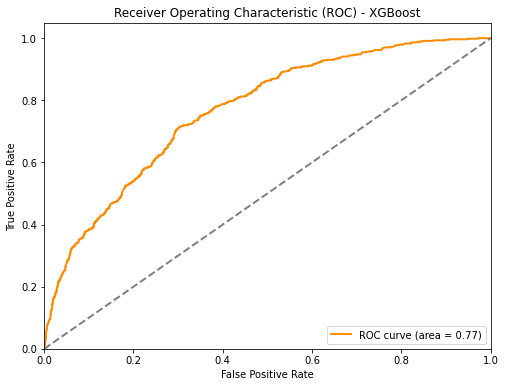

In [13]:
# calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc="lower right")
plt.show()

In [18]:
# late fusion data
results_df = pd.DataFrame({
    'Mortality': y_test,
    'Probability': y_pred_proba
}, index=X_test.index)

# save the DataFrame to a CSV file
results_df.to_csv('demo_xgb.csv', index=False)

# late fusion data
xgb_df = test_ids.to_frame(name='ID').merge(results_df, left_index=True, right_index=True)

xgb_df = xgb_df.reset_index(drop=True)

# save the DataFrame to a CSV file
xgb_df.to_csv('demo_xgb.csv', index=False)

In [19]:
print(roc_auc_score(results_df['Mortality'], results_df['Probability']))

0.7672102106841316
